In [1]:
USE_COLAB = True

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [2]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import pandas as pd
import glob as glob
import random
import os
import cv2
import numpy as np
from datetime import datetime
import sys

# 1. Create the dataset

## 1.1 Download the dataset

In [4]:
!wget -nc https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!tar xf object-detection-crowdai.tar.gz

--2025-11-21 14:13:14--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.44.142, 16.15.176.43, 16.182.104.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.44.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: ‘object-detection-crowdai.tar.gz’

object-detection-cr 100%[===================>]   1.54G  4.48MB/s    in 4m 11s  

2025-11-21 14:17:27 (6.27 MB/s) - ‘object-detection-crowdai.tar.gz’ saved [1650810880/1650810880]



In [5]:
!pwd
!ls 

/content
object-detection-crowdai  object-detection-crowdai.tar.gz  sample_data


## 1.2 Load the dataset

In [6]:
dataset_csv_path = '/content/object-detection-crowdai/labels.csv'
dataset_imgs_path = '/content/object-detection-crowdai'

In [7]:
!ls dataset_imgs_path

ls: cannot access 'dataset_imgs_path': No such file or directory


In [8]:
dataset_df = pd.read_csv(dataset_csv_path)

#### Preview Dataset

In [9]:
dataset_df.sample(5)

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
67213,1855,551,1920,733,1479505797969158328.jpg,Car,http://crowdai.com/images/t7mP_5XTxMRIa4c1/vis...
23369,784,569,850,631,1479501709194524705.jpg,Car,http://crowdai.com/images/gz6PVzNhAKAmukNe/vis...
46447,653,543,736,611,1479504101358382282.jpg,Car,http://crowdai.com/images/gDagjpaRP2Jxzaff/vis...
33461,0,429,474,866,1479502615254310339.jpg,Car,http://crowdai.com/images/Iz3fKDE-QWjiz1aH/vis...
47220,836,498,1536,1032,1479504165356990986.jpg,Car,http://crowdai.com/images/3w87uBnMIsXTQs5O/vis...


In [10]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72064 entries, 0 to 72063
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   xmin         72064 non-null  int64 
 1   xmax         72064 non-null  int64 
 2   ymin         72064 non-null  int64 
 3   ymax         72064 non-null  int64 
 4   Frame        72064 non-null  object
 5   Label        72064 non-null  object
 6   Preview URL  72064 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.8+ MB


In [11]:
classes_names = list(dataset_df['Label'].unique())
print(f"Classes names  = {classes_names}")

Classes names  = ['Car', 'Truck', 'Pedestrian']


#### Load the images

In [12]:
images_paths = glob.glob(os.path.join(dataset_imgs_path,"*.jpg"))

In [13]:
print(images_paths[:2])

['/content/object-detection-crowdai/1479502809766650134.jpg', '/content/object-detection-crowdai/1479503485311107105.jpg']


In [14]:
print(f"Total Number of objects aka bounding boxes = {len(dataset_df)} ")
print(f"Total Number of images in the dataset = {len(images_paths)} ")

Total Number of objects aka bounding boxes = 72064 
Total Number of images in the dataset = 9420 


In [15]:
images_names = [os.path.basename(image_path) for image_path in images_paths]

In [16]:
print(images_names[:2])

['1479502809766650134.jpg', '1479503485311107105.jpg']


In [17]:
print(f"Total Number of images in the dataset = {len(images_names)} ")

Total Number of images in the dataset = 9420 


## 1.3 Prepare the dataset

### Create Augemntations Transformations Class

In [ ]:
# class Augmentations():
#     ''' 
#         Define a random prob p for agumentation to be applied or not
#     '''
#     def get_prob(self):
#         np.random.choice([True, False], replace=False, p=[0.5,0.5])

#     ''' 
#         Increase Contrast with Value of 2
#     '''
#     def random_contrast_adjust(self, image, enable=None):
#         enable = self.get_prob() if enable is None else enable
#         return F.adjust_contrast(image,2) if enable else image
   
#     ''' 
#         Increase Brightness with Value of 2
#     '''
#     def random_brightness_adjust(self, image, enable=None):
#         enable = enable = self.get_probability() if enable is None else enable
#         return F.adjust_brightness(image,2) if enable else image
    
    
#     ''' 
#         Random Horizontal flip
#     '''
#     def random_hflip(self, image, boxes, enable=None):
#         enable = self.get_probability() if enable is None else enable
#         if enable:
#           #flip image
#           new_image = F.hflip(image)

#           #flip boxes
#           new_boxes = boxes.clone()
#           new_boxes[:, 0] = image.shape[2] - boxes[:, 0]  # image width - xmin
#           new_boxes[:, 2] = image.shape[2] - boxes[:, 2]  # image_width - xmax
#           new_boxes = new_boxes[:, [2, 1, 0, 3]]          # Interchange the xmin and xmax due to mirroring
#           return new_image, new_boxes
#         else:
#           return image, boxes


In [ ]:
class Augmentations:
    """
    Tensor-based augmentations for object detection images.
    All images are expected as PyTorch tensors with shape [C,H,W], values in [0,1].
    """

    def get_prob(self, p=0.5):
        """Return True with probability p, False otherwise"""
        return torch.rand(1).item() < p

    def random_contrast_adjust(self, image, enable=None, factor=2.0):
        """
        Adjust contrast for tensor image [C,H,W].
        image: torch.FloatTensor [C,H,W] values in [0,1]
        factor: contrast factor, >1 increases contrast
        """
        enable = self.get_prob() if enable is None else enable
        if enable:
            mean = image.mean(dim=[1,2], keepdim=True)   # mean per channel
            image = (image - mean) * factor + mean
            image = image.clamp(0,1)
        return image

    def random_brightness_adjust(self, image, enable=None, factor=0.5):
        """
        Adjust brightness for tensor image [C,H,W].
        factor: maximum brightness adjustment
        """
        enable = self.get_prob() if enable is None else enable
        if enable:
            adjustment = (torch.rand(1).item() * 2 - 1) * factor  # random in [-factor, +factor]
            image = (image + adjustment).clamp(0,1)
        return image

    def random_hflip(self, image, boxes, enable=None):
        """
        Random horizontal flip for tensor image and bounding boxes
        image: torch.FloatTensor [C,H,W]
        boxes: torch.FloatTensor [N,4] with [xmin,ymin,xmax,ymax]
        """
        enable = self.get_prob() if enable is None else enable
        if enable:
            # flip image
            image = torch.flip(image, dims=[2])  # flip width dimension

            # flip boxes
            new_boxes = boxes.clone()
            width = image.shape[2]
            new_boxes[:, 0] = width - boxes[:, 2]  # new xmin = width - old xmax
            new_boxes[:, 2] = width - boxes[:, 0]  # new xmax = width - old xmin
            return image, new_boxes
        return image, boxes

In [51]:
def transform_img(image):
    '''
        Convert OpenCV Image to RGB Image then to Tensor and Normalzie Values
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = torch.from_numpy(image).permute(2,0,1)

    return image

### Create Dataset Class

In [60]:
class Crowd_Dataset(Dataset):
    def __init__(self, images_path, labels_path,classes=None, transforms=None):
        super().__init__()
        print("Preparing the dataset...")
        self.removed_images = []

        # 1. Store passed arguments
        self.images_dir_path = images_path
        self.labels_path = labels_path
        self.classes = classes
        self.transforms = transforms

        # 2. Read dataset info as dataframe
        self.dataset_info_df = pd.read_csv(labels_path)

        # 3. Convert numeric columns
        numeric_columns = ['xmin', 'ymin', 'xmax', 'ymax']
        for col in numeric_columns:
            if col in self.dataset_info_df.columns:
                pd.to_numeric(self.dataset_info_df[col], errors='coerce') # invalid parsing convert to NaN

        # 4. Handle NaN values if exists
        if self.dataset_info_df[numeric_columns].isna().any().any():  # Check if (any) columns has (any) NaN
            print("Warning: Some bounding box coordinates could not be converted to numbers.")

        nan_rows_count = self.dataset_info_df[self.dataset_info_df[numeric_columns].isna().any(axis=1)].shape[0] # Rows where any columns is NaN
        print(f"Dropping {nan_rows_count} rows with NaN coordinates")

        self.dataset_info_df.dropna(subset=numeric_columns) # Drop rows where numeric columns has NaN values
        self.dataset_info_df.reset_index(drop=True) # Reset indicies to fix dropped rows indicies
        print(f"New Shape after dropping NaNs: {self.dataset_info_df.shape}")

        # 5. Check if header row is included with data
        header_row = self.dataset_info_df[self.dataset_info_df['Label'] == 'Label']
        if not header_row.empty:
                print(f"Found {len(header_row)} rows where 'Label' is literally 'Label'. These are likely header rows.")
                self.dataset_info_df = self.dataset_info_df[self.dataset_info_df['Label'] != 'Label'] # Keep only data rows which are not accidently header row
                self.dataset_info_df.reset_index(drop=True) # Reset indicies to fix dropped rows indicies

        # 6. Extract classes if not provided
        if self.classes is None:
            self.classes = sorted(self.dataset_info_df['Label'].unique().tolist())
        else:
            self.classes = classes
        print(f"Classes in dataset: {self.classes}")

        # 7. Create a list of images names in sorted order
        self.images_paths = glob.glob(f"{self.images_dir_path}/*.jpg")
        all_images_names = [image_path.split(os.path.sep)[-1] for image_path in self.images_paths] # /content/example/dataset/img_1.jpg
        self.all_images_names = sorted(all_images_names)
        print(f"Found {len(self.all_images_names)} images in directory")

        # 8. Encode Labels(Strings) To Labels(int) as indicies
        for i in range(len(self.dataset_info_df)): # Loop through all rows
            label_rowi = self.dataset_info_df.loc[i, 'Label']
            try:
                self.dataset_info_df.loc[i, 'Label'] = self.classes.index(label_rowi)
            except ValueError:
                if label_rowi != 'Label':  # Skip actual header rows
                    print(f"Warning: Label '{label_rowi}' not found in classes list. Adding it.")
                    self.classes.append(label_rowi) # Add New Class
                    self.dataset_info_df.loc[i, 'Label'] = self.classes.index(label_rowi)

        # 9. Filter the dataset
        self.filter_dataset() # Filter the dataset by removing images with no labels and incorrect bounding boxes

        print("Dataset preparation Done.")

    

    '''  
        Filter the dataset by removing images with no labels and incorrect bounding boxes
    '''
    def filter_dataset(self):
        # 1. Filter empty scenes images with no labels == Not in the dataset frame but in dataset dir
        for image_file in self.all_images_names.copy():
            if image_file not in self.dataset_info_df['Frame'].values:
                self.all_images_names.remove(image_file)
                self.removed_images.append(image_file)
        print(f"Images removed with no labels: {len(self.removed_images)}")
        

        # 2. Filter out rows with incorrect bboxes
       
        for col in ['xmin', 'ymin', 'xmax', 'ymax']:  # Ensure all coordinates are numeric before comparison
            if self.dataset_info_df[col].dtype == 'object':  # If column contains strings
                self.dataset_info_df[col] = pd.to_numeric(self.dataset_info_df[col], errors='coerce')
        self.dataset_info_df = self.dataset_info_df.reset_index(drop=True)   # Reset index to avoid KeyError when accessing rows

        valid_boxes_mask = (                                                                    # Find rows with incorrect bounding boxes (e.g. xmax=xmin)
                        (self.dataset_info_df['xmax'] - self.dataset_info_df['xmin'] > 0) &
                        (self.dataset_info_df['ymax'] - self.dataset_info_df['ymin'] > 0) 
                        )                                                                       # bool series with n=nrows with true where condition applied 
        invalid_boxes_count = (~valid_boxes_mask).sum() # Number of invalid bboxes
        print(f"Number of rows with incorrect bounding boxes: {invalid_boxes_count}")

        self.dataset_info_df = self.dataset_info_df[valid_boxes_mask] # Filter out rows with invalid boxes
        self.dataset_info_df = self.dataset_info_df.reset_index(drop=True) # Reset index again after filtering

        print(f"Final dataset shape: {self.dataset_info_df.shape}")
        print(f"Final number of images: {len(self.all_images_names)}")



    def __getitem__(self, idx):
        # Dict for ground truth labels and bboxes
        target = {}

        # Read input image
        image_name = self.all_images_names[idx]
        image_path = os.path.join(self.images_dir_path, image_name)
        print(image_path)
        image = cv2.imread(image_path)
        image_tensor = transform_img(image)    # Normlaize and convert to tensor

        # Get Ground Truth Information for the image
        gt_info = self.dataset_info_df[self.dataset_info_df['Frame'] == image_name]

        # Extact Labels and bboxes and convert to tensors
        boxes = torch.Tensor(gt_info[['xmin', 'ymin', 'xmax', 'ymax']].values).float()
        labels = torch.LongTensor(gt_info['Label'].values.tolist())

        # Apply Random Augmentations
        if self.transforms != None:
            image_tensor = self.transforms.random_contrast_adjust(image_tensor, enable=True)
            image_tensor = self.transforms.random_brightness_adjust(image_tensor, enable=True)
            image_tensor, boxes = self.transforms.random_hflip(image_tensor, boxes, enable=True)


        target["boxes"] = boxes     # Hint: Shape -> [N, 4] with N = Number of Boxes
        target["labels"] = labels   # Hint: Shape -> [N] with N = Number of Boxes

        return image_tensor, target
    

    def __len__(self):
        return len(self.all_images_names)
        

In [21]:
import matplotlib.patches as patches

def plot_image(img, boxes, scores, labels, dataset, save_path=None):
  '''
  Function that draws the BBoxes, scores, and labels on the image.

  inputs:
    img: input-image as numpy.array (shape: [H, W, C])
    boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
    labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
  '''

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(dataset)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(16, 8))
  # Display the image
  ax.imshow(img)
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = scores[i]
    width = box[2] - box[0] # [x_min,y_min,x_max,y_max]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  # Used to save inference phase results
  if save_path is not None:
    plt.savefig(save_path)

  plt.show()

In [61]:
dataset = Crowd_Dataset(dataset_imgs_path, dataset_csv_path, classes_names, transforms=Augmentations()) 

Preparing the dataset...
Dropping 0 rows with NaN coordinates
New Shape after dropping NaNs: (72064, 7)
Classes in dataset: ['Car', 'Truck', 'Pedestrian']
Found 9420 images in directory
Images removed with no labels: 202
Number of rows with incorrect bounding boxes: 52339
Final dataset shape: (19725, 7)
Final number of images: 9218
Dataset preparation Done.


In [46]:
!pwd
!ls
!ls /content/object-detection-crowdai/1479498374962942172.jpg

/content
object-detection-crowdai  object-detection-crowdai.tar.gz  sample_data
/content/object-detection-crowdai/1479498374962942172.jpg


/content/object-detection-crowdai/1479499772561599671.jpg
Image index:  1754


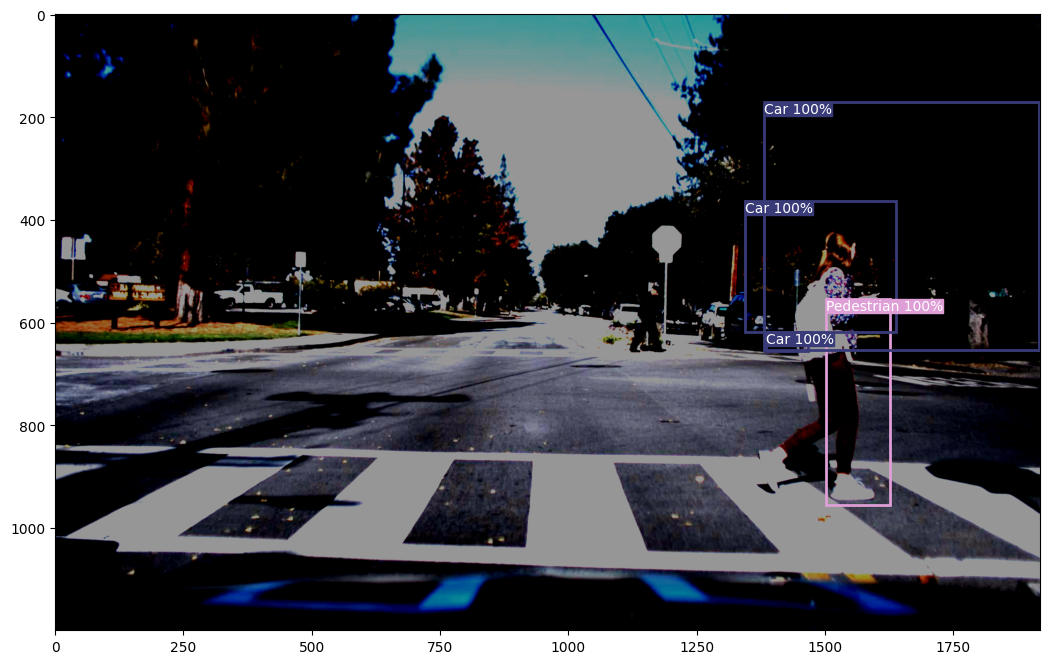

/content/object-detection-crowdai/1479499630049824830.jpg
Image index:  1565


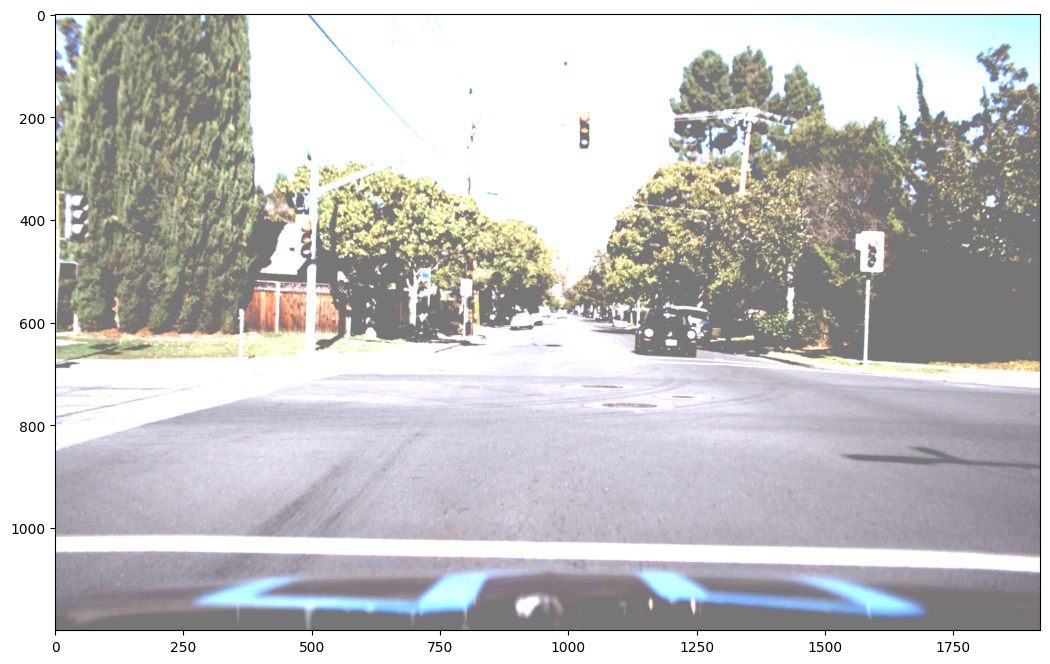

/content/object-detection-crowdai/1479499310007470746.jpg
Image index:  1162


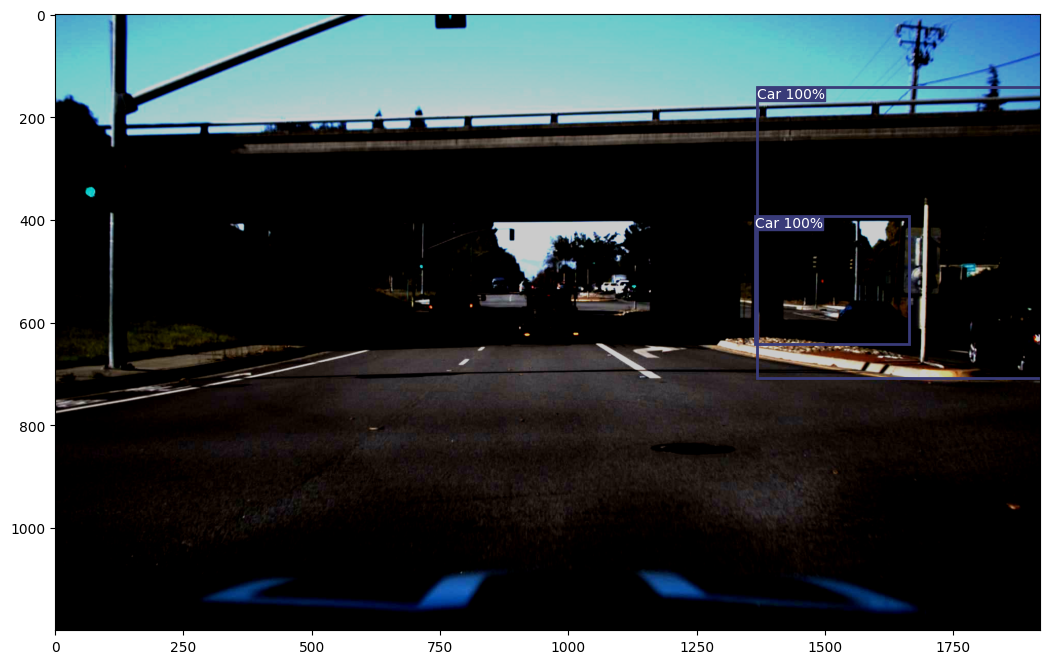

/content/object-detection-crowdai/1479500890635838673.jpg
Image index:  3165


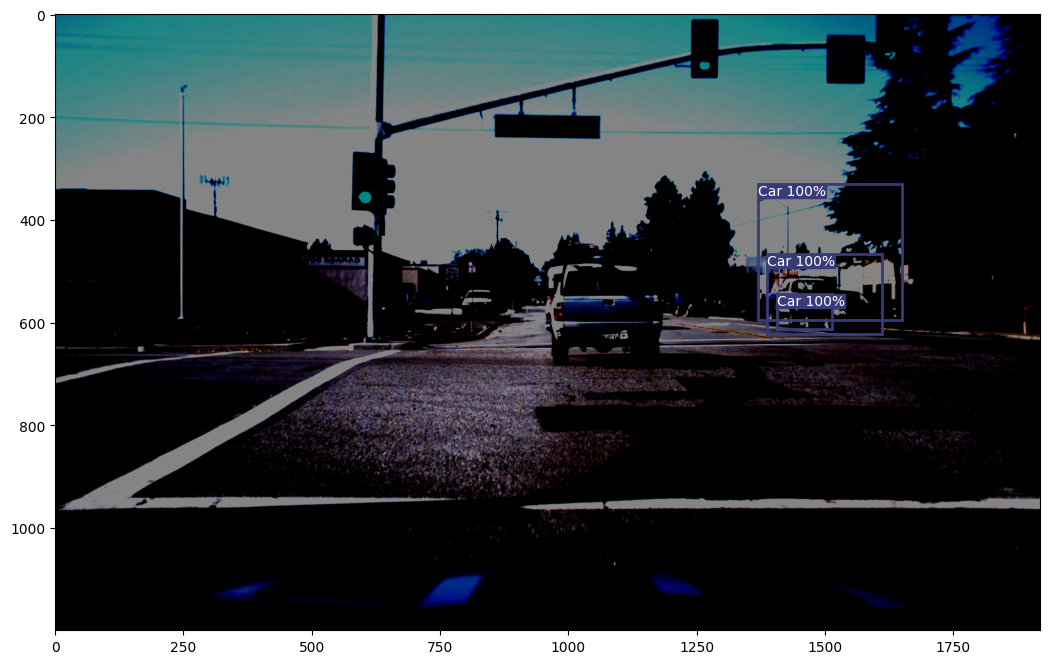

/content/object-detection-crowdai/1479498464966784770.jpg
Image index:  123


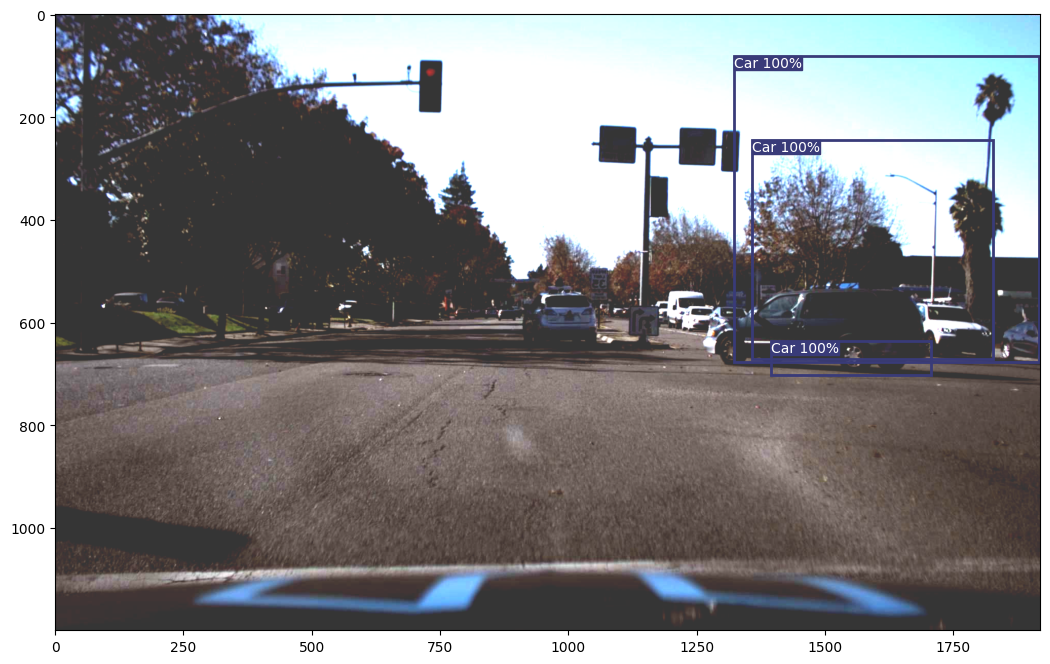

In [62]:
crowdai = ["Car", "Truck", "Pedestrian"]
num_images = 5

for _ in range(num_images):
  x = random.randint(0, (dataset.__len__()-1))
  img, target = dataset.__getitem__(x)
  img = img.permute(1,2,0).numpy()
  boxes = target['boxes'].numpy()
  labels = target['labels'].numpy()
  scores = [1]*len(labels)
  print("Image index: ", x)
  plot_image(img, boxes, scores, labels, crowdai)